In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch_pretrained_bert
!pip install git+https://github.com/huggingface/transformers

from transformers import TFBertForSequenceClassification, BertTokenizer, BertConfig, AdamWeightDecay
from sklearn.metrics import confusion_matrix
from xml.etree.ElementTree import parse
from pytorch_pretrained_bert import BertModel, BertTokenizer
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 6.8 MB/s 
     |████████████████████████████████| 132 kB 52.2 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 9.3 MB 66.8 MB/s 
     |████████████████████████████████| 140 kB 75.8 MB/s 
     |████████████████████████████████| 127 kB 77.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-4jhst4r1
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-4jhst4r1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel me

In [3]:
config = {
    "base_path": "drive/MyDrive/CS4248/MAMS-ATSA",
    "mode": "term",
    "glove_path": "drive/MyDrive/CS4248/glove.42B.300d.txt",
    "sentiment_path": "drive/MyDrive/CS4248/sentiment_dict.json",
    "max_vocab_size": None,
    "min_vocab_freq": 0,
    "lowercase": True
    }

In [4]:
polarity_to_ids = {"neutral": 2, "negative": 1, "positive": 0}

In [5]:
def get_data(file_name):
    path = config["base_path"] + "/raw/" + file_name
    tree = parse(path)
    sentences = tree.getroot()
    output = {"sentences": [], "terms": [], "polarities": []}
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue

        text = text.text
        text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
            
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            if polarity != "conflict":
                output["sentences"].append("[CLS] " + text + " [SEP] " + term + " [SEP]")
                output["terms"].append(term)
                output["polarities"].append(polarity_to_ids[polarity])
    return output

In [6]:
train_output = get_data("train.xml")
test_output = get_data("test.xml")
valid_output = get_data("val.xml")

In [7]:
train_labels = np.array(train_output["polarities"])
test_labels = np.array(test_output["polarities"])
valid_labels = np.array(valid_output["polarities"])

# train_labels = (train_output["polarities"])
# test_labels = (test_output["polarities"])
# valid_labels = (valid_output["polarities"])

In [8]:
sentences_train = train_output["sentences"]
sentences_test = test_output["sentences"]
sentences_valid = valid_output["sentences"]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts_train = [tokenizer.tokenize(sent) for sent in sentences_train]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]
tokenized_texts_valid = [tokenizer.tokenize(sent) for sent in sentences_valid]

100%|██████████| 231508/231508 [00:00<00:00, 1273923.32B/s]


In [9]:
max_token_length_train = max(map(lambda x: len(x), tokenized_texts_train))
max_token_length_test = max(map(lambda x: len(x), tokenized_texts_test))
max_token_length_valid = max(map(lambda x: len(x), tokenized_texts_valid))

In [10]:
print("Maximum number of tokens in each tweet from the training dataset is: "+str(max_token_length_train))
print("Maximum number of tokens in each tweet from the test dataset is: "+str(max_token_length_test))
print("Maximum number of tokens in each tweet from the validation dataset is: "+str(max_token_length_valid))

Maximum number of tokens in each tweet from the training dataset is: 106
Maximum number of tokens in each tweet from the test dataset is: 92
Maximum number of tokens in each tweet from the validation dataset is: 81


In [11]:
MAX_LEN = 110

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_train = np.array(pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"))

input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = np.array(pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"))

input_ids_valid = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_valid]
input_ids_valid = np.array(pad_sequences(input_ids_valid, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"))

In [12]:
sentences_train[:3]

['[CLS] the decor is not special at all but their food and amazing prices make up for it. [SEP] decor [SEP]',
 '[CLS] the decor is not special at all but their food and amazing prices make up for it. [SEP] food [SEP]',
 '[CLS] the decor is not special at all but their food and amazing prices make up for it. [SEP] prices [SEP]']

In [13]:
# Add some regularization to the model to reduce overfitting
configuration = BertConfig(hidden_dropout_prob = 0.15, num_labels = 3)

# Load model from pretrained model/vocabulary
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=configuration)

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Prepare training: 
# -. Compile tf.keras model with loss and learning rate schedule 
# -. Use AdamWeightDecay as the optimizer

with tf.device('/device:GPU:0'):
  optimizer = AdamWeightDecay(learning_rate=3e-05, epsilon=1e-08, clipnorm=1.0)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [15]:
# Check the configuration of the model

configuration = model.config
configuration

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.15,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [16]:
# Here's the summary of the model

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [17]:
# BERT can be easily overfitted, due to its model complexity.
# So in this case, the model is trained with 5 epochs only. 
# import os

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
# callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

history = model.fit(x=input_ids_train, y=train_labels, validation_data = (input_ids_valid, valid_labels), callbacks=[callback_1], epochs = 5, batch_size=32)

Epoch 1/5
350/350 [==============================] - 287s 754ms/step - loss: 0.8600 - accuracy: 0.5749 - val_loss: 0.5441 - val_accuracy: 0.7793
Epoch 2/5
350/350 [==============================] - 264s 754ms/step - loss: 0.4570 - accuracy: 0.8194 - val_loss: 0.4940 - val_accuracy: 0.8161
Epoch 3/5
350/350 [==============================] - 264s 754ms/step - loss: 0.2903 - accuracy: 0.8908 - val_loss: 0.5094 - val_accuracy: 0.8318
Epoch 4/5
350/350 [==============================] - 264s 754ms/step - loss: 0.1755 - accuracy: 0.9382 - val_loss: 0.5597 - val_accuracy: 0.8198
Epoch 5/5
350/350 [==============================] - 264s 755ms/step - loss: 0.1047 - accuracy: 0.9640 - val_loss: 0.6510 - val_accuracy: 0.8228


In [18]:
results = model.evaluate(input_ids_test, test_labels, batch_size = 32)

42/42 [==============================] - 10s 242ms/step - loss: 0.6294 - accuracy: 0.8496


In [19]:
results

[0.6293606162071228, 0.8495509028434753]

In [20]:
prediction = model.predict(input_ids_test).logits

42/42 [==============================] - 13s 238ms/step


In [21]:
prediction

array([[ 2.7374866 , -2.91062   ,  0.5043101 ],
       [ 4.280576  , -2.0481606 , -1.8416067 ],
       [ 4.3185024 , -2.7293417 , -1.1670192 ],
       ...,
       [-2.1732464 , -2.7618546 ,  4.773845  ],
       [-1.8557916 ,  4.427856  , -3.1712909 ],
       [ 0.55619574,  1.2625098 , -2.1259322 ]], dtype=float32)

In [22]:
final_prediction = []

for i in range(len(prediction)):
  final_prediction.append(np.argmax(prediction[i]))

print(final_prediction)

[0, 0, 0, 1, 1, 2, 0, 2, 1, 2, 2, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 0, 1, 0, 0, 1, 2, 1, 0, 1, 0, 2, 1, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 1, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0, 2, 1, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 

In [23]:
confusion_matrix(test_labels, final_prediction)

array([[340,  24,  36],
       [ 23, 276,  30],
       [ 46,  42, 519]])

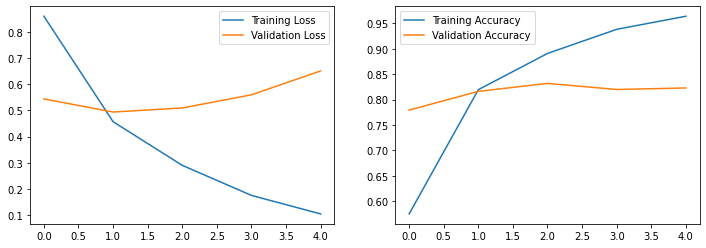

<Figure size 432x288 with 0 Axes>

In [24]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
  plt.subplot(1, 2, i + 1)
  plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
  plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
  plt.legend()
plt.show()
plt.savefig('bert_accuracy.png')